# How many zero and low emissions vehicles are registered in California?

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from pywaffle import Waffle
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# CARB looks for ways to meet our 5 million zero-emission vehicle target by 2030, the conversion of public and private fleets to zero emission cars and trucks offers an important opportunity to get a large number of carbon-polluting fleet vehicles off the road.
# https://ww2.arb.ca.gov/sites/default/files/2018-12/zero_emission_fleet_letter_080118.pdf

### Read data from California Department of Motor Vehicles - current as of October 2018

In [3]:
# https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code

In [4]:
src = pd.read_csv('https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/resource/4254a06d-9937-4083-9441-65597dd267e8/download/vehicle-count-as-of-1-1-2020.csv', low_memory=False)

In [5]:
df = src.copy()

### Clean up field names

In [6]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [7]:
df.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [8]:
'{:,.0f}'.format(df.vehicles.sum())

'31,233,841'

In [9]:
df.columns

Index(['date', 'zip', 'model_year', 'fuel', 'make', 'duty', 'vehicles'], dtype='object')

### Remove unknown, out of state and heavy duty models.

In [10]:
vehicles = pd.DataFrame(df[(df['duty'] != 'Heavy') & \
                          (df['model_year'] != '<2007') &\
                          (df['zip'] != 'OOS')])

### What's left?

In [11]:
'{:,.0f}'.format(vehicles.vehicles.sum())

'19,132,886'

### How many don't rely solely on gasoline?

In [12]:
nogas = vehicles[(vehicles['fuel'] != 'Gasoline')]

In [13]:
'{:,.0f}'.format(nogas.vehicles.sum())

'2,824,578'

### Filter the data frame for fuel zero-emissions fuel types

In [14]:
cvrp_now = vehicles[(vehicles['fuel'] == 'Battery Electric') |\
               (vehicles['fuel'] == 'Hydrogen Fuel Cell') |\
                   (vehicles['fuel'] == 'Plug-in Hybrid')]

In [15]:
cvrp = vehicles[(vehicles['fuel'] == 'Battery Electric') |\
               (vehicles['fuel'] == 'Hydrogen Fuel Cell')]

### How many are zero emissions under 2035 standard?

In [16]:
'{:,.0f}'.format(cvrp.vehicles.sum())

'308,182'

In [17]:
'{:,.0f}'.format(cvrp_now.vehicles.sum())

'554,403'

### Share of newer CA vehicles that don't rely solely on gas?

In [18]:
'{:,.1f}%'.format((nogas.vehicles.sum() / vehicles.vehicles.sum())*100)

'14.8%'

### Share of CA vehicles that are zero emissions?

In [19]:
'{:,.1f}%'.format((cvrp.vehicles.sum() / vehicles.vehicles.sum())*100)

'1.6%'

In [20]:
'{:,.1f}%'.format((cvrp_now.vehicles.sum() / vehicles.vehicles.sum())*100)

'2.9%'

---

### ZIP code points

In [21]:
zips_point = gpd.read_file('/Users/mhustiles/data/data/GIS/zipcodes.geojson')

In [22]:
zips_point['zip'] = zips_point['zip'].astype(str)

In [23]:
ca_zips_point = zips_point[zips_point['state'] == 'CA']

### ZIP code boundaries

In [24]:
# Filtered CA from this national file maintained by Esri: 
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri.geojson')
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri-demographics.geojson')

In [25]:
zips_poly.columns = zips_poly.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [26]:
zips_poly.dropna(inplace=True)

In [27]:
zips_poly.rename(columns={"zip_code": "zip"}, inplace=True)

In [28]:
zips_poly.head(1)

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.27703 37.53436, -122.27687 37.5..."


---

### Zip Codes with economic demographics by Esri

In [29]:
#https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/WealthiestZipCodes2017/FeatureServer/0/
zips_wealth = gpd.read_file('input/WealthiestZipCodesCA.json')

In [30]:
zips_wealth.head(1)

,OBJECTID,ID,NAME,ST_ABBREV,HAI_CY,INCMORT_CY,WLTHRNK_CY,DOMSTATE,DOMCOUNTY,COUNTY_NAME,DOMCBSA,CBSA_NAME,TOTPOP_CY,TOTHH_CY,MEDAGE_CY,AVGHINC_CY,AVGVAL_CY,AVGNW_CY,Shape__Area,Shape__Length,geometry
0,29014,90001,Los Angeles,CA,55,44.10,"27,675.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",59907,13454,27.10,46931,377591,82915,"12,747,932.74","17,936.35","POLYGON ((-118.24329 33.98901, -118.24754 33.9..."


In [31]:
zips_wealth_slim = zips_wealth[['ID','NAME', 'AVGHINC_CY', 'AVGNW_CY', 'TOTPOP_CY', 'geometry']]

In [32]:
zips_esri = zips_wealth_slim.rename(columns={"ID": "zip",
                                                    'NAME':'name',
                                 'AVGHINC_CY':'avg_house_income',
                                 'AVGNW_CY':'avg_net_worth',
                                 'TOTPOP_CY':'population', })

In [33]:
zips_esri.head()

,zip,name,avg_house_income,avg_net_worth,population,geometry
0,90001,Los Angeles,46931,82915,59907,"POLYGON ((-118.24329 33.98901, -118.24754 33.9..."
1,90002,Los Angeles,46332,96786,53573,"POLYGON ((-118.23085 33.95772, -118.23108 33.9..."
2,90003,Los Angeles,43020,66091,71967,"MULTIPOLYGON (((-118.28268 33.98926, -118.2826..."
3,90004,Los Angeles,65893,232653,63987,"MULTIPOLYGON (((-118.33852 34.06891, -118.3371..."
4,90005,Los Angeles,53191,105569,41844,"POLYGON ((-118.31879 34.05514, -118.31852 34.0..."


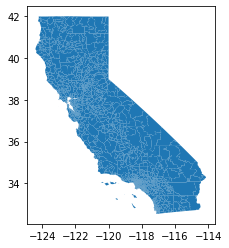

In [34]:
zips_esri.plot()

---

### Group the vehicles and count them by the registration ZIP Codes

In [35]:
zipcodes = vehicles.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

In [36]:
zipcodes.sort_values(by='vehicles', ascending=False).head(10)
zipcodes['zip'] = zipcodes['zip'].astype(str)

### Merge the registration zip codes and merge with Esri ZIP Codes polygons

In [37]:
zips = pd.merge(zips_esri, zipcodes, left_on='zip', right_on='zip')

In [38]:
zips.head()

,zip,name,avg_house_income,avg_net_worth,population,geometry,vehicles
0,90001,Los Angeles,46931,82915,59907,"POLYGON ((-118.24329 33.98901, -118.24754 33.9...",17374
1,90002,Los Angeles,46332,96786,53573,"POLYGON ((-118.23085 33.95772, -118.23108 33.9...",15951
2,90003,Los Angeles,43020,66091,71967,"MULTIPOLYGON (((-118.28268 33.98926, -118.2826...",20918
3,90004,Los Angeles,65893,232653,63987,"MULTIPOLYGON (((-118.33852 34.06891, -118.3371...",22597
4,90005,Los Angeles,53191,105569,41844,"POLYGON ((-118.31879 34.05514, -118.31852 34.0...",12410


---

### Group by make. Which are most common? 

In [39]:
# About 2.5 are listed as OTHER/UNK
make = vehicles[vehicles['make'] != 'OTHER/UNK'].groupby(['make', 'zip']).agg('sum').reset_index()

In [40]:
most_make = make.groupby(['make']).agg('sum').reset_index().sort_values(by='vehicles', ascending=False)

In [41]:
most_make.head()

,make,vehicles
46,TOYOTA,3456367
18,HONDA,2378676
14,FORD,1559171
35,NISSAN,1305700
9,CHEVROLET,1253237


In [42]:
makelist = most_make.make.to_list()

In [43]:
popular_makes = make[make['make'].isin(makelist)]

In [44]:
make_zip = pd.DataFrame(pd.pivot_table(popular_makes, values='vehicles', \
                            index=['zip'], columns=['make'], aggfunc=np.sum, fill_value=0).reset_index())

In [45]:
make_zip.columns = make_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which make is most common in each ZIP code? 

In [46]:
make_zip["total"] = make_zip.sum(axis=1)

In [47]:
make_zip.sort_values(by='total', ascending=False).head(5)

make,zip,acura,alfa_romeo,am_general,aston_martin,audi,bentley,bmw,buick,cadillac,chevrolet,chrysler,dodge,ferrari,fiat,ford,freightliner,genesis,gmc,honda,hummer,hyundai,infiniti,jaguar,jeep,kia,lamborghini,land_rover,lexus,lincoln,maserati,mazda,mercedes_benz,mercury,mini,mitsubishi,nissan,pontiac,porsche,ram,rolls_royce,saturn,scion,smart,subaru,suzuki,tesla,toyota,unk,volkswagen,volvo,vpg,workhorse,total
42,90045,316,14,0,0,750,0,1859,1628,605,9801,3347,8409,0,84,15525,0,0,2749,2972,0,5164,983,413,4309,6242,0,665,1067,253,0,2435,1497,0,228,3166,13078,0,204,1442,0,0,59,0,624,0,352,17164,6758,3324,266,0,0,117752
942,94080,758,0,0,0,463,0,1570,434,571,13558,1761,4681,0,38,10767,0,0,683,5740,0,5166,780,132,2410,8840,0,236,1573,229,0,1087,1765,0,244,154,15560,23,128,992,0,16,286,0,1139,0,334,16979,3775,2415,81,0,0,105368
481,92336,440,0,0,0,461,0,1412,158,440,5573,502,1248,0,81,3940,0,0,545,8266,13,1646,605,15,1090,2425,0,48,1458,30,0,953,1610,0,203,223,5439,44,38,459,0,68,589,0,585,0,218,9746,723,869,51,0,0,52214
254,91709,790,41,0,0,716,0,2429,85,344,2682,244,567,0,50,3487,0,25,339,7229,0,1788,744,40,910,1376,0,226,2789,23,72,1122,2862,0,268,114,2254,0,341,281,0,39,377,0,897,0,683,9284,554,963,214,0,0,47249
129,90650,426,0,0,0,340,0,1032,129,215,3494,411,1345,0,48,3021,0,0,590,7977,0,1726,448,0,1072,2343,0,11,1102,33,0,829,801,0,149,248,4340,30,85,364,0,87,748,0,451,0,89,10094,496,701,11,0,0,45286


In [48]:
makes_list = list(make_zip.columns)

In [49]:
makes_list

['zip',
 'acura',
 'alfa_romeo',
 'am_general',
 'aston_martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'ferrari',
 'fiat',
 'ford',
 'freightliner',
 'genesis',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'land_rover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mercedes_benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'pontiac',
 'porsche',
 'ram',
 'rolls_royce',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'unk',
 'volkswagen',
 'volvo',
 'vpg',
 'workhorse',
 'total']

In [50]:
make_zip[['zip', 'total']].to_csv('output/total_makes_zip.csv')

In [51]:
make_total = pd.DataFrame(make_zip[['zip', 'total']])

In [52]:
make_zip['winner'] = make_zip[['acura',
 'acura',
 'alfa_romeo',
 'am_general',
 'aston_martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'ferrari',
 'fiat',
 'ford',
 'freightliner',
 'genesis',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'land_rover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mercedes_benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'pontiac',
 'porsche',
 'ram',
 'rolls_royce',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'unk',
 'volkswagen',
 'volvo',
 'vpg',
 'workhorse']].idxmax(axis=1)

In [53]:
make_zip.head(10)

make,zip,acura,alfa_romeo,am_general,aston_martin,audi,bentley,bmw,buick,cadillac,chevrolet,chrysler,dodge,ferrari,fiat,ford,freightliner,genesis,gmc,honda,hummer,hyundai,infiniti,jaguar,jeep,kia,lamborghini,land_rover,lexus,lincoln,maserati,mazda,mercedes_benz,mercury,mini,mitsubishi,nissan,pontiac,porsche,ram,rolls_royce,saturn,scion,smart,subaru,suzuki,tesla,toyota,unk,volkswagen,volvo,vpg,workhorse,total,winner
0,90001,52,0,0,0,11,0,344,14,57,1670,181,663,0,0,1032,0,0,123,2471,0,398,169,0,455,1034,0,0,170,12,0,147,169,0,78,11,2564,28,0,114,0,27,235,0,51,0,0,3306,158,191,0,0,0,15935,toyota
1,90002,20,0,0,0,13,0,240,13,72,1561,193,641,0,0,926,0,0,97,2149,0,371,200,0,356,1113,0,0,176,0,0,121,174,0,0,47,2447,28,0,44,0,38,221,0,41,0,0,3009,111,212,0,0,0,14634,toyota
2,90003,83,0,0,0,41,0,332,11,102,1808,252,818,0,0,1179,0,0,153,2978,0,433,239,0,418,1408,0,0,247,12,0,212,303,0,0,68,3106,38,0,94,0,37,338,0,25,0,0,4355,159,277,0,0,0,19526,toyota
3,90004,227,32,0,0,563,0,1075,0,37,680,11,220,0,105,774,0,0,11,3144,0,778,218,30,410,686,0,141,1176,0,0,487,889,0,262,31,1812,0,141,0,0,0,238,0,422,0,200,5250,179,678,114,0,0,21021,toyota
4,90005,62,0,0,0,241,0,759,0,0,260,0,52,0,15,341,0,12,0,1769,0,610,143,0,153,401,0,30,822,0,0,203,640,0,78,0,877,0,50,0,0,0,39,0,192,0,58,2638,108,320,0,0,0,10873,toyota
5,90006,62,0,0,0,113,0,564,0,0,664,12,203,0,25,618,0,0,15,2706,0,751,182,0,243,788,0,0,712,0,0,203,456,0,86,0,2015,0,0,13,0,0,178,0,119,0,26,4477,131,320,28,0,0,15710,toyota
6,90007,0,0,0,0,182,0,414,0,0,509,14,153,0,0,495,0,0,0,1551,0,253,37,0,270,558,0,0,130,0,0,154,250,0,44,0,1153,0,53,0,0,0,57,0,90,0,27,2206,102,287,0,0,0,8989,toyota
7,90008,36,0,0,0,200,0,499,49,171,785,159,273,0,17,629,0,0,14,1397,0,437,219,0,287,695,0,0,437,0,0,184,728,0,52,0,1123,12,15,0,0,0,14,0,91,0,54,1801,55,328,25,0,0,10786,toyota
8,90010,0,0,0,0,81,0,317,0,77,60,0,60,0,0,463,0,13,37,278,0,261,43,0,68,87,0,89,191,0,0,0,666,0,0,0,104,0,106,0,0,0,0,0,17,0,39,1455,364,12,15,0,0,4903,toyota
9,90011,171,0,0,0,101,0,416,0,127,2643,267,1071,0,12,1633,0,0,261,4381,0,537,326,0,685,1692,0,0,297,29,0,310,312,0,25,97,4364,13,0,129,0,49,416,0,115,0,0,5994,195,394,11,0,0,27073,toyota


In [54]:
make_zip_top_ten = pd.DataFrame(make_zip[['zip','dodge','toyota','gmc','honda','ford','chevrolet','nissan',\
                               'bmw','hyundai','lexus','mercedes_benz','kia', 'total']])

In [55]:
make_zip_top_ten.to_csv('output/make_zip_top_ten.csv')

In [56]:
make_zip_top_ten.head()

make,zip,dodge,toyota,gmc,honda,ford,chevrolet,nissan,bmw,hyundai,lexus,mercedes_benz,kia,total
0,90001,663,3306,123,2471,1032,1670,2564,344,398,170,169,1034,15935
1,90002,641,3009,97,2149,926,1561,2447,240,371,176,174,1113,14634
2,90003,818,4355,153,2978,1179,1808,3106,332,433,247,303,1408,19526
3,90004,220,5250,11,3144,774,680,1812,1075,778,1176,889,686,21021
4,90005,52,2638,0,1769,341,260,877,759,610,822,640,401,10873


### How many Bentleys are there? 

In [57]:
bentley = pd.DataFrame(make_zip[['zip','bentley','total']])

In [58]:
bentley.bentley.sum()

464

---

### Isolate vehicle makes to include only Teslas

In [59]:
tesla = vehicles[(vehicles['make'] == 'TESLA')]

In [60]:
tesla.vehicles.sum()

174092

### Group by ZIP code and count the vehicles

In [61]:
tesla_grouped = tesla.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

### Merge with dataframe that includes all vehicle counts by ZIP code

In [62]:
tesla_zips = pd.merge(tesla_grouped, zips, on='zip')

### Rename the columns

In [63]:
tesla_zips.rename(columns={'median': 'income','zip': 'zip', \
                           'vehicles_x':'teslas', 'vehicles_y':'all_vehicles'}, inplace=True)

### Normalize Tesla ownership to a rate per 1,000 vehicles

In [64]:
tesla_zips['tesla_rate_1k'] = ((tesla_zips.teslas / tesla_zips.all_vehicles) * 1000).round(2)

In [65]:
tesla_zips.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,teslas,name,avg_house_income,avg_net_worth,population,geometry,all_vehicles,tesla_rate_1k
563,94027,527,Atherton,297732,3680197,7230,"POLYGON ((-122.22896 37.42448, -122.22801 37.4...",5132,102.69
560,94022,1227,Los Altos,248970,3041961,20626,"MULTIPOLYGON (((-122.17849 37.32593, -122.1787...",13697,89.58
608,94301,764,Palo Alto,224861,1760729,18694,"MULTIPOLYGON (((-122.15390 37.43499, -122.1540...",9338,81.82
561,94024,1210,Los Altos,259185,3442702,23198,"POLYGON ((-122.06023 37.32855, -122.05966 37.3...",14870,81.37
564,94028,358,Portola Valley,263238,3322715,6639,"MULTIPOLYGON (((-122.19602 37.34043, -122.1965...",4794,74.68
744,95070,1586,Saratoga,243915,3157204,32730,"MULTIPOLYGON (((-122.03172 37.21454, -122.0317...",21379,74.18
416,92657,573,Newport Coast,244565,2836260,11464,"POLYGON ((-117.80038 33.60682, -117.80545 33.6...",8297,69.06
640,94539,1931,Fremont,198198,2070851,54673,"POLYGON ((-121.93794 37.59103, -121.93776 37.5...",31330,61.63
731,95030,568,Los Gatos,233429,2476366,13618,"MULTIPOLYGON (((-121.95302 37.21059, -121.9535...",9309,61.02
772,95138,710,San Jose,181584,1376395,19789,"MULTIPOLYGON (((-121.74690 37.22353, -121.7482...",11800,60.17


In [66]:
tesla_breaks \
= jenkspy.jenks_breaks(tesla_zips.tesla_rate_1k, nb_class=6)
tesla_breaks

[0.34, 5.76, 12.83, 23.61, 38.9, 61.63, 102.69]

In [67]:
tesla_zips.to_csv('output/tesla_zips.csv')

In [68]:
tesla_zips_slim = pd.DataFrame(tesla_zips[['zip','name','teslas','all_vehicles','tesla_rate_1k', 'avg_house_income', 'avg_net_worth']])

In [69]:
tesla_zips_slim.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
563,94027,Atherton,527,5132,102.69,297732,3680197
560,94022,Los Altos,1227,13697,89.58,248970,3041961
608,94301,Palo Alto,764,9338,81.82,224861,1760729
561,94024,Los Altos,1210,14870,81.37,259185,3442702
564,94028,Portola Valley,358,4794,74.68,263238,3322715
744,95070,Saratoga,1586,21379,74.18,243915,3157204
416,92657,Newport Coast,573,8297,69.06,244565,2836260
640,94539,Fremont,1931,31330,61.63,198198,2070851
731,95030,Los Gatos,568,9309,61.02,233429,2476366
772,95138,San Jose,710,11800,60.17,181584,1376395


### How predictive is income  

In [70]:
tesla_zips.head()

,zip,teslas,name,avg_house_income,avg_net_worth,population,geometry,all_vehicles,tesla_rate_1k
0,90004,200,Los Angeles,65893,232653,63987,"MULTIPOLYGON (((-118.33852 34.06891, -118.3371...",22597,8.85
1,90005,58,Los Angeles,53191,105569,41844,"POLYGON ((-118.31879 34.05514, -118.31852 34.0...",12410,4.67
2,90006,26,Los Angeles,42242,39289,61184,"POLYGON ((-118.28425 34.05586, -118.28453 34.0...",17142,1.52
3,90007,27,Los Angeles,38564,39966,45381,"POLYGON ((-118.27622 34.01303, -118.27402 34.0...",10520,2.57
4,90008,54,Los Angeles,56286,284531,34600,"POLYGON ((-118.31710 34.01644, -118.31825 34.0...",12562,4.30


In [71]:
tesla_zips_corr = tesla_zips_slim[['tesla_rate_1k', 'avg_house_income']]

In [72]:
corr = tesla_zips_corr.corr(method ='pearson')

In [73]:
print(corr)

                  tesla_rate_1k  avg_house_income
tesla_rate_1k              1.00              0.83
avg_house_income           0.83              1.00


In [74]:
alt.Chart(tesla_zips_slim).mark_circle(size=60).encode(
    x=alt.X('tesla_rate_1k:Q', title='Tesla rate per 1,000 vehicles', axis=alt.Axis(tickCount=6)),
    y=alt.Y('avg_net_worth:Q', title='Avg net worth', axis=alt.Axis(tickCount=5, format='$,N')),
    tooltip=['zip:N', 'teslas:O', 'avg_net_worth:Q', 'tesla_rate_1k:Q']
).properties(width=500, height=500)

alt.Chart(...)

In [75]:
tesla_zips_slim.to_csv('output/tesla_zips_slim.csv')

---

### Group by model year. Which years have the most vehicles? 

In [76]:
model_year = vehicles.groupby(['model_year']).agg('sum').reset_index()

In [77]:
model_year.sort_values(by='model_year', ascending=False)

,model_year,vehicles
14,Unk,2061
13,2020,214848
12,2019,1669729
11,2018,1973495
10,2017,2028101
9,2016,1876624
8,2015,1882332
7,2014,1572085
6,2013,1528019
5,2012,1259806


In [78]:
model_year_chart = alt.Chart(model_year).mark_bar().encode(
).mark_bar().encode(
    y=alt.Y('model_year:N', title=" ", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("vehicles:Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

model_year_chart_text = model_year_chart.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('vehicles:Q', format=',')
)

(model_year_chart + model_year_chart_text).properties(height=500, \
                                                      width=700, title='California vehicles, by model year')

alt.LayerChart(...)

### Export model year table for graphics

In [79]:
model_year.to_csv('output/model_year.csv')

---

## Fuel types

### Which types of alternative fuel models are most common?

In [80]:
fuel = vehicles.groupby(['fuel']).agg('sum').reset_index()

In [81]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,301616
1,Diesel and Diesel Hybrid,310610
2,Flex-Fuel,944558
3,Gasoline,16308308
4,Hybrid Gasoline,1008378
5,Hydrogen Fuel Cell,6566
6,Natural Gas,6273
7,Other,356
8,Plug-in Hybrid,246221


In [82]:
fuel.fuel.tolist()

['Battery Electric',
 'Diesel and Diesel Hybrid',
 'Flex-Fuel',
 'Gasoline',
 'Hybrid Gasoline',
 'Hydrogen Fuel Cell',
 'Natural Gas',
 'Other',
 'Plug-in Hybrid']

In [83]:
# Diesel and Diesel Hybrid + Flex-Fuel + Gasoline + Hybrid Gasoline
'{:,.0f}'.format((fuel.iloc[1,1] + fuel.iloc[2,1] + fuel.iloc[3,1] + fuel.iloc[4,1]))

'18,571,854'

# Chart the fuel type counts

In [84]:
chart_fuels = alt.Chart(fuel).mark_bar().encode(
    y=alt.Y('fuel:N', title=' ',
        sort=alt.EncodingSortField(
            field="vehicles",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

chart_fuels_text = chart_fuels.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text('sum(vehicles)', format=',')
)


(chart_fuels + chart_fuels_text)\
.properties(height=400, width=500, title='CA alternative fuel vehicles by type')

alt.LayerChart(...)

### Export fuel type count table for graphics

In [85]:
fuel.to_csv('output/fuel.csv')

--- 

## Where are these vehicles?

In [86]:
zip_code = vehicles.groupby(['zip']).agg('sum').reset_index()

In [87]:
zip_code_cvrp = cvrp.groupby(['zip']).agg('sum').reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [88]:
zip_code_cvrp.sort_values(by='vehicles',\
    ascending=False).head(10)

,zip,vehicles
1230,94539,2942
1387,95014,2657
1255,94568,2227
1267,94582,2160
1424,95070,2158
1229,94538,2048
1143,94087,1907
1400,95035,1901
511,92130,1892
1438,95120,1825


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [89]:
sum_by_zip = pd.pivot_table(vehicles, values='vehicles', \
                            index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()

sum_by_zip.columns = sum_by_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which type is most common in each ZIP code? 

In [90]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [91]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
45,90045,561,184,9476,103988,4717,25,6,1,468,119426
2358,94080,529,328,5290,96600,3912,7,3,0,329,106998
1258,92336,370,632,2428,47907,1884,11,31,1,555,53819
783,91709,931,616,1642,42349,2516,49,24,0,908,49035
327,90650,211,292,1951,42525,1470,4,16,0,329,46798


### Group the lesser-used fuel types into an 'other' category

In [92]:
sum_by_zip['other'] = sum_by_zip.apply\
    (lambda x: x['hydrogen_fuel_cell'] + x['natural_gas'] + x['other'], axis=1)
sum_by_zip.drop(['hydrogen_fuel_cell', 'natural_gas'], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [93]:
sum_by_zip['winner'] = \
sum_by_zip[['hybrid_gasoline','battery_electric','diesel_and_diesel_hybrid',\
                   'flex_fuel','plug_in_hybrid', 'other']].idxmax(axis=1)

In [94]:
sum_by_zip.sort_values(by='total', ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
45,90045,561,184,9476,103988,4717,32,468,119426,flex_fuel
2358,94080,529,328,5290,96600,3912,10,329,106998,flex_fuel
1258,92336,370,632,2428,47907,1884,43,555,53819,flex_fuel
783,91709,931,616,1642,42349,2516,73,908,49035,hybrid_gasoline
327,90650,211,292,1951,42525,1470,20,329,46798,flex_fuel
1101,92154,168,382,2100,42409,1366,7,175,46607,flex_fuel
1533,92683,524,313,1251,41162,2291,51,587,46179,hybrid_gasoline
1445,92592,433,1060,2192,38841,2297,15,601,45439,hybrid_gasoline
615,91342,220,583,2149,39892,1913,16,368,45141,flex_fuel
784,91710,415,760,2532,38530,1628,50,539,44454,flex_fuel


### De-slugify the 'winner' category

In [95]:
sum_by_zip['winner'] = sum_by_zip['winner'].str.replace('_', ' ', regex=False).str.capitalize()

In [96]:
sum_by_zip['altshare'] = (((sum_by_zip['total']-sum_by_zip['gasoline'])/sum_by_zip['total'])*100).round()

In [97]:
sum_by_zip['batteryshare'] = ((sum_by_zip['battery_electric']/sum_by_zip['total'])*100)

In [101]:
sum_by_zip.sort_values(by='batteryshare', ascending=False).tail()

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare,batteryshare
2871,95085,0,0,0,2,1,0,0,3,Hybrid gasoline,33.00,0.00
2872,95086,0,0,0,2,0,0,0,2,Hybrid gasoline,0.00,0.00
2873,95087,0,0,1,1,0,0,0,2,Flex fuel,50.00,0.00
2874,95088,0,0,0,2,0,0,0,2,Hybrid gasoline,0.00,0.00
4703,99999,0,0,0,4,0,0,0,4,Hybrid gasoline,0.00,0.00


### Use the "jenks" method to set fair breaks for total field

In [103]:
sum_by_zip.dtypes

fuel
zip                          object
battery_electric              int64
diesel_and_diesel_hybrid      int64
flex_fuel                     int64
gasoline                      int64
hybrid_gasoline               int64
other                         int64
plug_in_hybrid                int64
total                         int64
winner                       object
altshare                    float64
batteryshare                float64
dtype: object

In [105]:
breaks = jenkspy.jenks_breaks(list(sum_by_zip['batteryshare']), nb_class=5)

In [106]:
breaks

[0.0, 1.9607843137254901, 9.262687519948932, 28.57142857142857, 50.0, 100.0]

---

### Export merged polygon geodataframe as GeoJSON

In [107]:
zips_poly.to_file('/Users/mhustiles/data/data/GIS/zips_poly.geojson', driver='GeoJSON')

In [108]:
zips_poly_merged = zips_poly.merge(sum_by_zip, on='zip')

In [109]:
zips_poly_merged.columns

Index(['objectid', 'zip', 'po_name', 'pop2012', 'white', 'black', 'ameri_es',
       'asian', 'hawn_pi', 'hispanic', 'other_x', 'mult_race', 'med_age',
       'ave_hh_sz', 'marhh_chd', 'families', 'ave_fam_sz', 'hse_units', 'sqmi',
       'geometry', 'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
       'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
       'winner', 'altshare', 'batteryshare'],
      dtype='object')

In [110]:
# zips_poly_merged_drop = ['objectid', 'zip', 'po_name', 'sqmi', 
#                         'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
#                          'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
#                          'winner', 'altshare']
# zips_poly_merged.drop(zips_poly_merged_drop, inplace=True, axis=1)

In [111]:
zips_poly_merged.to_file('/Users/mhustiles/data/data/GIS/zips_poly_merged.geojson', driver='GeoJSON')

### Export with Tesla totals

In [112]:
tesla_zips_poly_merged = zips_poly.merge(tesla_zips_slim, on='zip')

In [113]:
tesla_zips_poly_merged.to_file('/Users/mhustiles/data/data/fuel/tesla_zips_poly_merged.geojson', driver='GeoJSON')

In [114]:
tesla_zips_poly_merged.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.27703 37.53436, -122.27687 37.5...",Belmont,595,16130,36.89,153464,1318219
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.37728 37.60562, -122.37738 37.6...",Burlingame,1217,35012,34.76,182761,1704921
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.90,2.09,593,2749,2.70,6609,43.20,"POLYGON ((-120.77255 35.46196, -120.77270 35.4...",Morro Bay,12,5754,2.09,77336,671582
3,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.50283 37.70813, -122.50242 37.7...",Daly City,220,30113,7.31,101482,696394
4,4803,94019,Half Moon Bay,18476,14195,137,128,718,20,5533,2646,693,42.30,2.75,1729,4653,3.23,7132,73.10,"MULTIPOLYGON (((-122.42875 37.60415, -122.4331...",Half Moon Bay,169,8961,18.86,151305,1312367


### Merge ZIP points with Tesla & electric totals

In [115]:
teslas_point_merged = ca_zips_point.merge(tesla_zips_slim, on='zip')

In [116]:
teslas_point_merged.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,city,state,geometry,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
563,94027,Atherton,CA,POINT (-122.20000 37.44000),Atherton,527,5132,102.69,297732,3680197
560,94022,Los Altos,CA,POINT (-122.14000 37.36000),Los Altos,1227,13697,89.58,248970,3041961
608,94301,Palo Alto,CA,POINT (-122.15000 37.44000),Palo Alto,764,9338,81.82,224861,1760729
561,94024,Los Altos,CA,POINT (-122.11000 37.34000),Los Altos,1210,14870,81.37,259185,3442702
564,94028,Portola Valley,CA,POINT (-122.21000 37.37000),Portola Valley,358,4794,74.68,263238,3322715
744,95070,Saratoga,CA,POINT (-122.06000 37.25000),Saratoga,1586,21379,74.18,243915,3157204
416,92657,Newport Coast,CA,POINT (-117.82000 33.60000),Newport Coast,573,8297,69.06,244565,2836260
640,94539,Fremont,CA,POINT (-121.89000 37.51000),Fremont,1931,31330,61.63,198198,2070851
731,95030,Los Gatos,CA,POINT (-121.99000 37.22000),Los Gatos,568,9309,61.02,233429,2476366
772,95138,San Jose,CA,POINT (-121.73000 37.24000),San Jose,710,11800,60.17,181584,1376395


In [117]:
teslas_point_merged.to_file('output/teslas_point_merged.geojson', driver='GeoJSON')

### Merge ZIP points with all vehicle totals

In [118]:
ca_zips_point_merged = ca_zips_point.merge(sum_by_zip, on='zip')

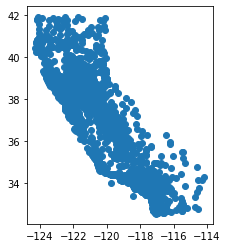

In [119]:
ca_zips_point_merged.plot()

### Export merged points geodataframe as GeoJSON

In [120]:
ca_zips_point_merged.head(5)

,zip,city,state,geometry,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare,batteryshare
0,90001,Los Angeles,CA,POINT (-118.24000 33.97000),21,105,790,15955,453,4,46,17374,Flex fuel,8.00,0.12
1,90002,Los Angeles,CA,POINT (-118.24000 33.94000),31,52,765,14659,394,0,50,15951,Flex fuel,8.00,0.19
2,90003,Los Angeles,CA,POINT (-118.27000 33.96000),25,54,912,19336,541,7,43,20918,Flex fuel,8.00,0.12
3,90004,Los Angeles,CA,POINT (-118.31000 34.07000),345,79,417,19646,1789,19,302,22597,Hybrid gasoline,13.00,1.53
4,90005,Los Angeles,CA,POINT (-118.31000 34.05000),116,51,215,11019,840,5,164,12410,Hybrid gasoline,11.00,0.93


In [121]:
ca_zips_point_merged.to_file('/Users/mhustiles/data/data/fuel/ca_zips_point_merged.geojson', driver='GeoJSON')

### Convert polygons to mbtiles for Mapbox. Export.

In [122]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/data/fuel/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/data/fuel/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
2543 features, 176920 bytes of geometry, 16 bytes of separate metadata, 89634 bytes of string pool
  99.9%  13/1411/3271  


### Convert points to mbtiles for Mapbox. Export.

In [123]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/data/fuel/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/data/fuel/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
2543 features, 176920 bytes of geometry, 16 bytes of separate metadata, 89634 bytes of string pool
  99.9%  13/1371/3199  


### Convert Tesla polygons to mbtiles for Mapbox. Export.

In [124]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/data/fuel/tesla_zips_poly_merged.mbtiles \
/Users/mhustiles/data/data/fuel/tesla_zips_poly_merged.geojson

For layer 0, using name "tesla_zips_poly_merged"
877 features, 1765409 bytes of geometry, 49951 bytes of separate metadata, 86279 bytes of string pool
  99.9%  13/1419/3283  


---

## Waffle plot

In [125]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,301616
1,Diesel and Diesel Hybrid,310610
2,Flex-Fuel,944558
3,Gasoline,16308308
4,Hybrid Gasoline,1008378
5,Hydrogen Fuel Cell,6566
6,Natural Gas,6273
7,Other,356
8,Plug-in Hybrid,246221


In [126]:
fuel.vehicles.sum()

19132886

In [127]:
fuel.iloc[0,1] + fuel.iloc[5,1] + fuel.iloc[6,1] + fuel.iloc[7,1]

314811

In [128]:
fuel['per_1000'] =  ((fuel['vehicles'] / fuel.vehicles.sum()) * 1000).round(2)

In [129]:
fuel

,fuel,vehicles,per_1000
0,Battery Electric,301616,15.76
1,Diesel and Diesel Hybrid,310610,16.23
2,Flex-Fuel,944558,49.37
3,Gasoline,16308308,852.37
4,Hybrid Gasoline,1008378,52.70
5,Hydrogen Fuel Cell,6566,0.34
6,Natural Gas,6273,0.33
7,Other,356,0.02
8,Plug-in Hybrid,246221,12.87


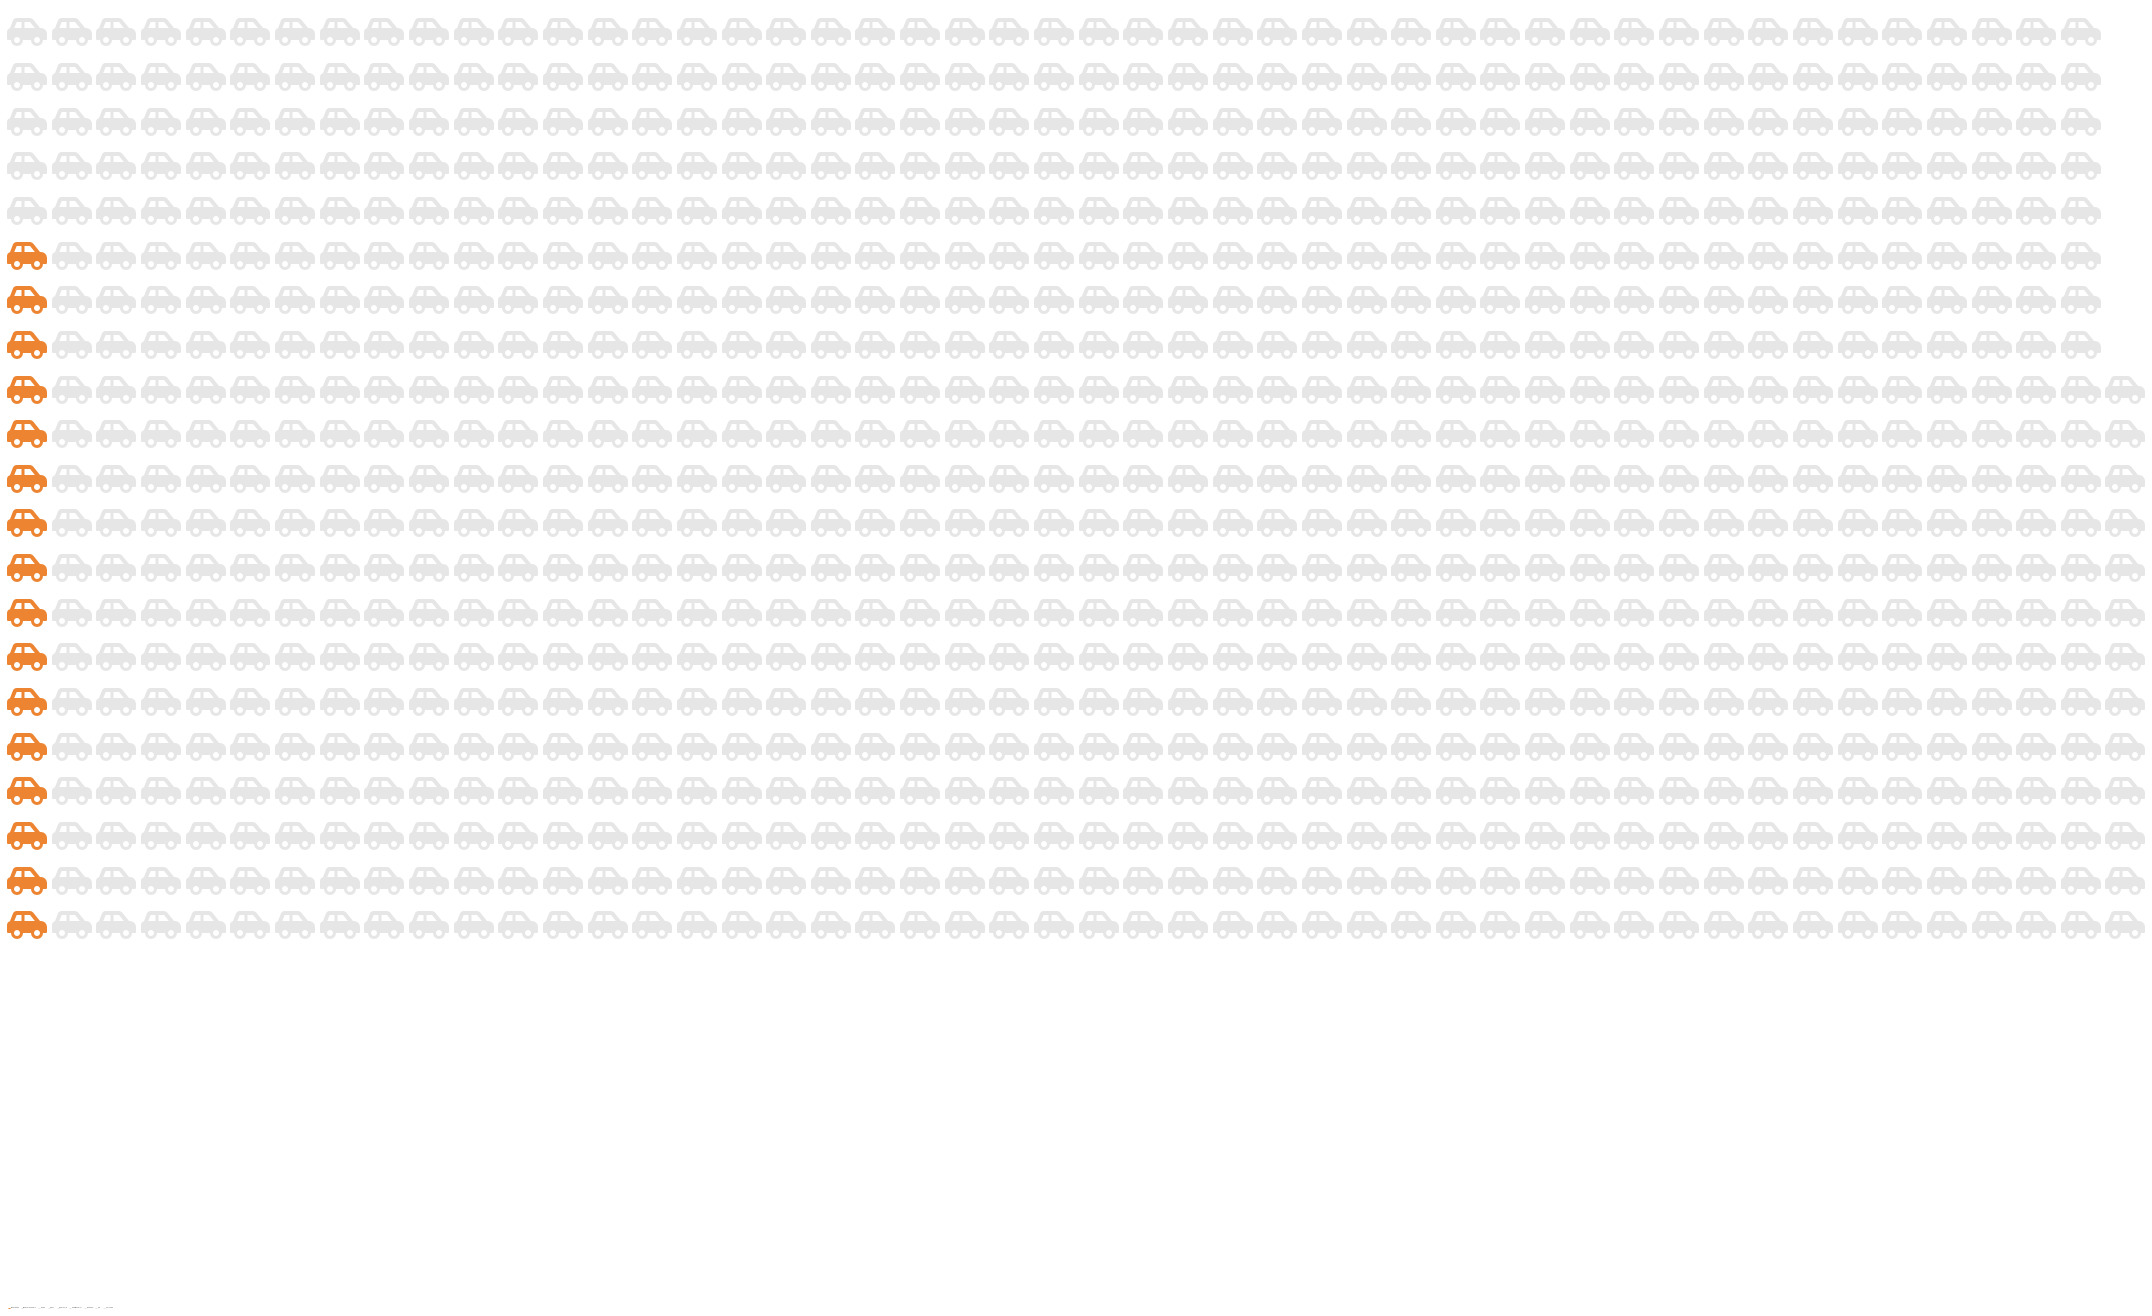

In [130]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=21,
    values=fuel.per_1000,
    labels=list(fuel.fuel),
    figsize=(30,20),
    icons='car-side',
    colors=['#ec8431','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6', '#e6e6e6', '#e6e6e6'],
    icon_legend=False
    legend={
        'loc': 'lower left',
        'bbox_to_anchor': (0, -0.4),
        'ncol': len(fuel),
        'framealpha': 0,
        'fontsize': 0
    }
)

See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)